In [1]:
import sys
import time
import pickle
import gzip
from random import randint
from scipy import misc
import scipy.ndimage
from scipy.sparse import csc_matrix, issparse
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans,MiniBatchKMeans
import matplotlib.pyplot as plt
import json
import csv
import collections
import math
import sys

#setting path
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN = 'data_training'
IMAGES_TEST = 'data_testing'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

#import data+label
data_training = DATA_PATH+IMAGES_TRAIN
data_testing = DATA_PATH+IMAGES_TEST
ft = gzip.open(data_training, 'rb')
TRAINING = pickle.load(ft)
ft.close()
ft = gzip.open(data_testing, 'rb')
TESTING = pickle.load(ft)
ft.close()

In [2]:
import logging

logNN = logging.getLogger('NN')
logNN.propagate = False
logNN.setLevel(logging.DEBUG)

fh1 = logging.FileHandler('log/nn4.log')
fh1.setLevel(logging.DEBUG)

ch1 = logging.StreamHandler()
ch1.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fh1.setFormatter(formatter)
ch1.setFormatter(formatter)

logNN.addHandler(fh1)
logNN.addHandler(ch1)

In [3]:
def ReLU (x, derivate = False):
    if not derivate:
        return x * (x > 0)
    else:
        return 1 * (x > 0)
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [125]:
class NN:
    def __init__(self, neurons, training, testing, lr, mu, minibatch=None):
        self.numEx, self.numTest = 60000, 10000
        self.neurons=neurons
        self.training=training
        self.testing=testing
        self.lr = lr
        self.mu = mu
        self.minibatch=minibatch
        
        #initalizate He at al.
        self.Wh = np.random.randn(N_FEATURES, self.neurons) * math.sqrt(2.0/self.numEx)
        self.bh = np.random.randn(1, self.neurons) * math.sqrt(2.0/self.numEx)
        self.Wo = np.random.randn(self.neurons, 10) * math.sqrt(2.0/self.numEx)
        self.bo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
     
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def predict(self, X):
        outputs=[]
        H=ReLU(np.dot(X, self.Wh)+self.bh)
        outputs.append(H)
        outputs.append(sigmoid((np.dot(H, self.Wo))+self.bo))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch / nEpochs)
        #lr = 10**(-4) + 10**(-1)/math.sqrt(self.epoch+1)
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])        
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) #X[indexLow:indexHigh].T
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += delta_h + momentumUpdate * self.vh
            self.bh += delta_bh + momentumUpdate * self.vbh
            self.Wo += delta_o + momentumUpdate * self.vo  
            self.bo += delta_bo + momentumUpdate * self.vbo
            
            self.vh = delta_h
            self.vbh = delta_bh
            self.vo = delta_o  
            self.vbo = delta_bo
        

    def updateMiniBatch(self, X, t, learningRate):        
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch/400 )
        
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])   
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden)
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += delta_h
            self.bh += delta_bh
            self.Wo += delta_o  
            self.bo += delta_bo
        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
        
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 200
       
        accIter = 0
        
        self.start_time = dt.datetime.now()
        logNN.info("neurons= "+str(self.neurons)+" learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        #logNN.info("learning rate="+str(self.lr)+" Vanilla minibatch(100)")
        while num_epochs >= self.epoch: #not self.stop_iterate(accIter):
            #self.updateMiniBatch(train, self.targetForUpd, self.lr)
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
          #  if self.epoch % 100 == 0:
           #     logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [103]:
class NN_pr:
    def __init__(self, neurons, training, testing, lr, mu, minibatch, weights, pruning):
        self.numEx, self.numTest = 60000, 10000
        self.neurons=neurons
        self.training=training
        self.testing=testing
        self.lr = lr
        self.mu = mu
        self.minibatch=minibatch
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
            
        self.pruning = pruning
         
        Wh = self.pruned_matrix(weights[0])
        Wo = self.pruned_matrix(weights[1])
        self.Wh = Wh[0]
        self.maskh = Wh[1]
        self.Wo = Wo[0]
        self.masko = Wo[1]
        self.bh = weights[2]
        self.bo = weights[3]
        
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def predict(self, X):
        outputs=[]
        H=ReLU(np.dot(X, self.Wh)+self.bh) #* self.maskh
        outputs.append(H)
        outputs.append(sigmoid((np.dot(H, self.Wo))+self.bo)) # * self.masko
        return outputs
    
    def pruned_matrix(self, W):
        treshold = self.pruning / 2 
        percentile_down = np.percentile (W, treshold)
        percentile_up = np.percentile (W, 100 - treshold)
        
        m1 = (W >= percentile_down) 
        m2 = (W <= percentile_up)
        mask = m1 * m2

        return W*mask, mask

    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch / nEpochs)
       
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])        
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) #X[indexLow:indexHigh].T
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += (delta_h + momentumUpdate * self.vh) * self.maskh
            self.bh += delta_bh + momentumUpdate * self.vbh
            self.Wo += (delta_o + momentumUpdate * self.vo) * self.masko
            self.bo += delta_bo + momentumUpdate * self.vbo
           
            self.vh = delta_h
            self.vbh = delta_bh
            self.vo = delta_o  
            self.vbo = delta_bo
        
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
    
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 100
        accIter = 0
        logNN.info("neurons="+str(self.neurons)+" learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        logNN.info("remove "+str(self.pruning)+"% of connection")
        
        while num_epochs >= self.epoch: #not self.stop_iterate(accIter):
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
          #  if self.epoch % 100 == 0:
           #     logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
                        
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)

In [124]:
class NN_pr1:
    def __init__(self, neurons, training, testing, lr, mu, minibatch, weights, pruning):
        self.numEx, self.numTest = 60000, 10000
        self.neurons=neurons
        self.training=training
        self.testing=testing
        self.lr = lr
        self.mu = mu
        self.minibatch=minibatch
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
            
        self.pruning = pruning
         
        self.maskh = self.pruned_mask(weights[0])
        self.masko = self.pruned_mask(weights[1])
        
        self.Wh = np.random.randn(N_FEATURES, self.neurons) * math.sqrt(2.0/self.numEx)*self.maskh
        self.bh = np.random.randn(1, self.neurons) * math.sqrt(2.0/self.numEx)
        self.Wo = np.random.randn(self.neurons, 10) * math.sqrt(2.0/self.numEx)*self.masko
        self.bo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def predict(self, X):
        outputs=[]
        H=ReLU(np.dot(X, self.Wh)+self.bh) #* self.maskh
        outputs.append(H)
        outputs.append(sigmoid((np.dot(H, self.Wo))+self.bo)) # * self.masko
        return outputs
    
    def pruned_mask(self, W):
        treshold = self.pruning / 2 
        percentile_down = np.percentile (W, treshold)
        percentile_up = np.percentile (W, 100 - treshold)
        
        m1 = (W >= percentile_down) 
        m2 = (W <= percentile_up)
        mask = m1 * m2

        return mask

    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch / nEpochs)
       
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])        
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) #X[indexLow:indexHigh].T
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += (delta_h + momentumUpdate * self.vh) * self.maskh
            self.bh += delta_bh + momentumUpdate * self.vbh
            self.Wo += (delta_o + momentumUpdate * self.vo) * self.masko
            self.bo += delta_bo + momentumUpdate * self.vbo
           
            self.vh = delta_h
            self.vbh = delta_bh
            self.vo = delta_o  
            self.vbo = delta_bo
        
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
    
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 200
        accIter = 0
        logNN.info("neurons="+str(self.neurons)+" learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        logNN.info("remove "+str(self.pruning)+"% of connection")
        
        while num_epochs >= self.epoch: #not self.stop_iterate(accIter):
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
          #  if self.epoch % 100 == 0:
           #     logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
                        
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)

In [70]:
trl1=[]
tel1=[]

for n in [100, 150, 200, 250, 300]:
    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
    tr, te = nn.train()
    trl1.append(tr)
    tel1.append(te)
    for p in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]:     
        nn_pr = NN_pr(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
        tr, te = nn_pr.train()
        trl1.append(tr)
        tel1.append(te)

2019-05-23 22:44:49,439 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 22:44:51,160 - INFO - epoch: 0:  89.59
2019-05-23 22:46:13,135 - INFO - epoch: 41:  98.8
2019-05-23 22:46:13,248 - INFO - Accuracy on Test: 97.69
2019-05-23 22:46:14,019 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 22:46:14,019 - INFO - remove 5% of connection
2019-05-23 22:46:15,981 - INFO - epoch: 0:  96.03
2019-05-23 22:47:21,338 - INFO - epoch: 32:  98.99
2019-05-23 22:47:21,493 - INFO - Accuracy on Test: 97.57
2019-05-23 22:47:22,396 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 22:47:22,397 - INFO - remove 10% of connection
2019-05-23 22:47:24,304 - INFO - epoch: 0:  94.63
2019-05-23 22:48:33,338 - INFO - epoch: 37:  98.92
2019-05-23 22:48:33,430 - INFO - Accuracy on Test: 97.49
2019-05-23 22:48:34,055 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 

2019-05-23 23:30:27,720 - INFO - epoch: 35:  98.96
2019-05-23 23:30:27,866 - INFO - Accuracy on Test: 97.9
2019-05-23 23:30:28,877 - INFO - neurons=200 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 23:30:28,878 - INFO - remove 30% of connection
2019-05-23 23:30:32,235 - INFO - epoch: 0:  91.16
2019-05-23 23:32:20,723 - INFO - epoch: 31:  98.46
2019-05-23 23:32:20,865 - INFO - Accuracy on Test: 97.36
2019-05-23 23:32:21,869 - INFO - neurons=200 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 23:32:21,870 - INFO - remove 40% of connection
2019-05-23 23:32:25,255 - INFO - epoch: 0:  89.71
2019-05-23 23:35:42,579 - INFO - epoch: 56:  98.41
2019-05-23 23:35:42,724 - INFO - Accuracy on Test: 97.44
2019-05-23 23:35:43,754 - INFO - neurons=200 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 23:35:43,755 - INFO - remove 50% of connection
2019-05-23 23:35:47,194 - INFO - epoch: 0:  88.99
2019-05-23 23:38:59,619 - INFO - epoch: 55:  97.74
20

KeyboardInterrupt: 

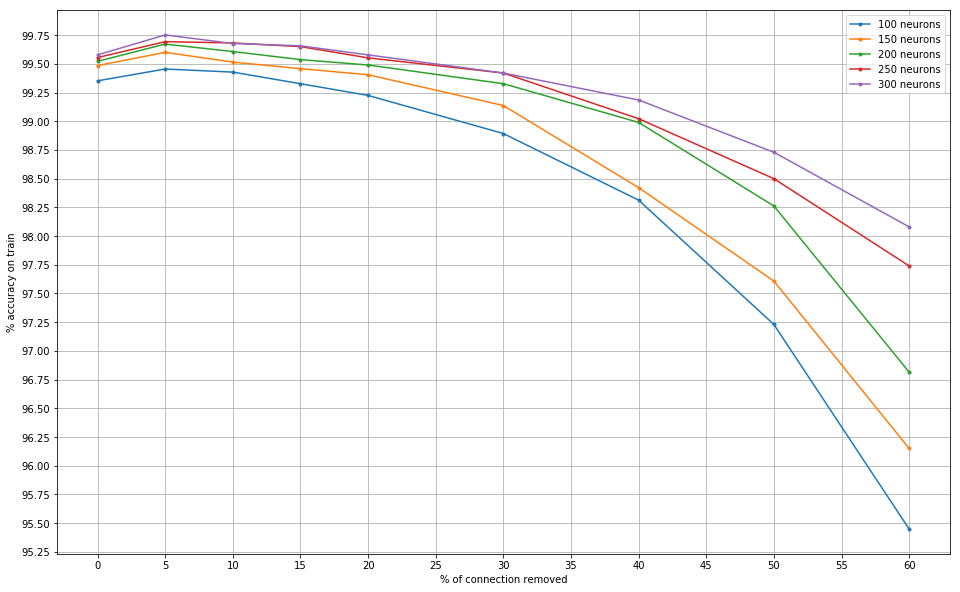

In [117]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],trl3[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(95, 100, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on train")
plt.grid() 
plt.plot()

plt.savefig('train.png')

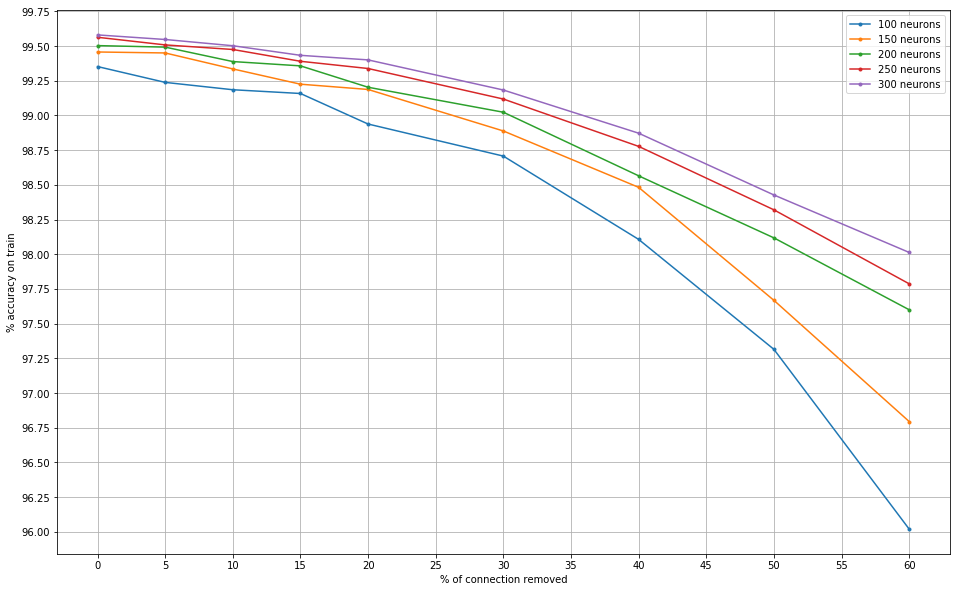

In [122]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],trl4[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(95, 100, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on train")
plt.grid() 
plt.plot()

plt.savefig('train1.png')

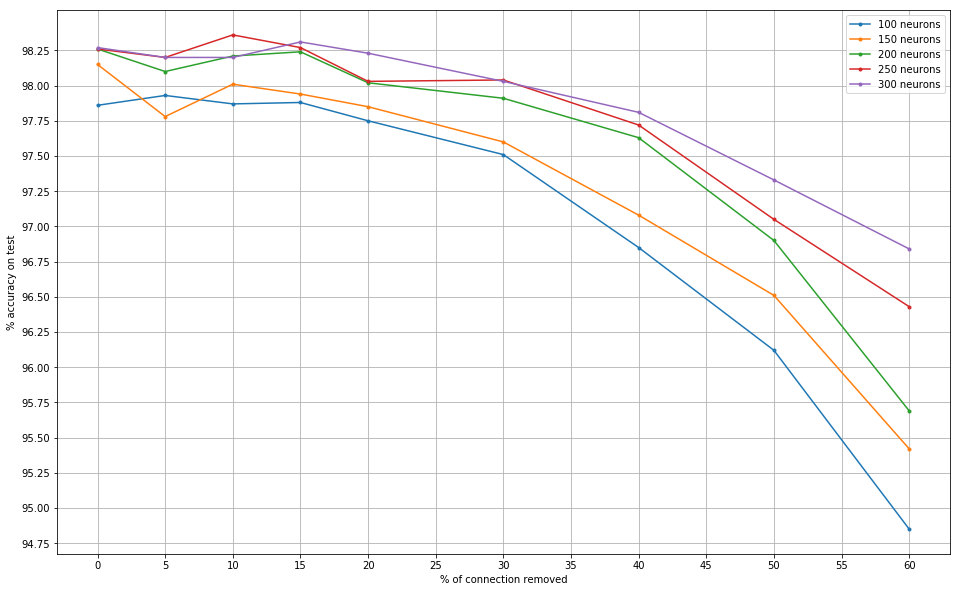

In [118]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],tel3[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(94.5, 98.5, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on test")
plt.grid() 
plt.plot()
plt.savefig('test.png')

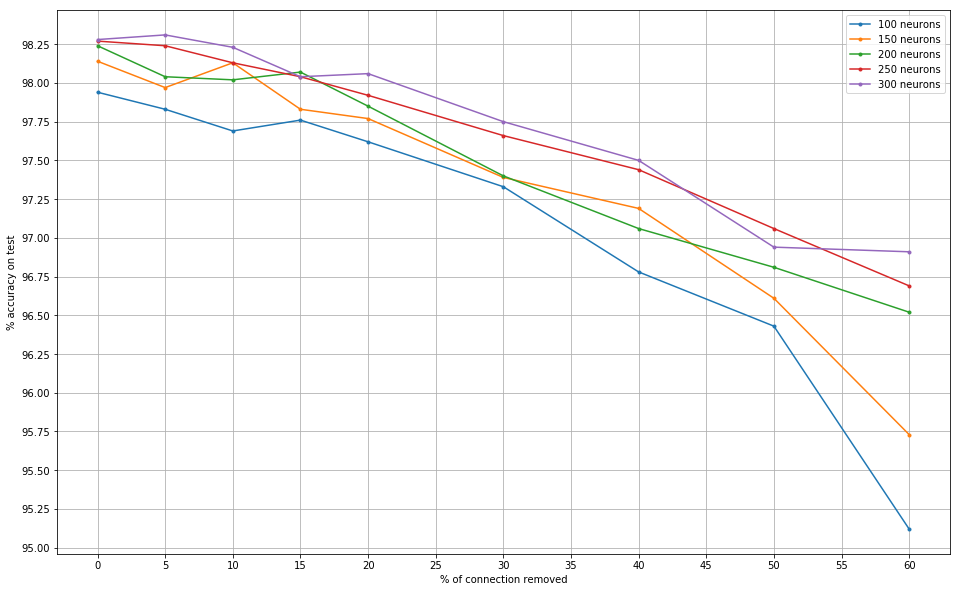

In [123]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],tel4[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(94.5, 98.5, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on test")
plt.grid() 
plt.plot()
plt.savefig('test1.png')

In [120]:
trl4=[]
tel4=[]

for n in [100, 150, 200, 250, 300]:
    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
    tr, te = nn.train()
    trl4.append(tr)
    tel4.append(te)
    for p in [5, 10, 15, 20, 30, 40, 50, 60]:     
        nn_pr = NN_pr1(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
        tr, te = nn_pr.train()
        trl4.append(tr)
        tel4.append(te)

2019-05-25 12:40:56,849 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 12:43:46,783 - INFO - epoch: 101:  99.352
2019-05-25 12:43:47,042 - INFO - Accuracy on Test: 97.94
2019-05-25 12:43:47,665 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 12:43:47,666 - INFO - remove 5% of connection
2019-05-25 12:46:42,408 - INFO - epoch: 101:  99.238
2019-05-25 12:46:42,496 - INFO - Accuracy on Test: 97.83
2019-05-25 12:46:43,122 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 12:46:43,122 - INFO - remove 10% of connection
2019-05-25 12:49:39,869 - INFO - epoch: 101:  99.185
2019-05-25 12:49:39,959 - INFO - Accuracy on Test: 97.69
2019-05-25 12:49:40,585 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 12:49:40,586 - INFO - remove 15% of connection
2019-05-25 12:52:37,362 - INFO - epoch: 101:  99.158
2019-05-25 12:52:37,451 - INFO - Accuracy o

2019-05-25 15:09:53,474 - INFO - epoch: 101:  99.338
2019-05-25 15:09:53,870 - INFO - Accuracy on Test: 97.92
2019-05-25 15:09:55,590 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 15:09:56,445 - INFO - remove 30% of connection
2019-05-25 15:16:50,006 - INFO - epoch: 101:  99.118
2019-05-25 15:16:50,185 - INFO - Accuracy on Test: 97.66
2019-05-25 15:16:51,437 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 15:16:51,438 - INFO - remove 40% of connection
2019-05-25 15:23:44,250 - INFO - epoch: 101:  98.777
2019-05-25 15:23:44,412 - INFO - Accuracy on Test: 97.44
2019-05-25 15:23:45,608 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 15:23:45,609 - INFO - remove 50% of connection
2019-05-25 15:30:37,807 - INFO - epoch: 101:  98.32
2019-05-25 15:30:37,972 - INFO - Accuracy on Test: 97.06
2019-05-25 15:30:39,156 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 m

In [126]:
trl5=[]
tel5=[]

for n in [100, 150, 200, 250, 300]:
    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
    tr, te = nn.train()
    trl5.append(tr)
    tel5.append(te)
    for p in [5, 10, 15, 20, 30, 40, 50, 60]:     
        nn_pr = NN_pr1(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
        tr, te = nn_pr.train()
        trl5.append(tr)
        tel5.append(te)

2019-05-25 18:40:45,518 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 18:46:33,498 - INFO - epoch: 201:  99.5
2019-05-25 18:46:33,870 - INFO - Accuracy on Test: 98.03
2019-05-25 18:46:34,594 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 18:46:34,595 - INFO - remove 5% of connection
2019-05-25 18:52:28,430 - INFO - epoch: 201:  99.48
2019-05-25 18:52:28,576 - INFO - Accuracy on Test: 98.0
2019-05-25 18:52:29,202 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 18:52:29,203 - INFO - remove 10% of connection
2019-05-25 18:58:29,807 - INFO - epoch: 201:  99.443
2019-05-25 18:58:29,900 - INFO - Accuracy on Test: 97.87
2019-05-25 18:58:30,540 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 18:58:30,540 - INFO - remove 15% of connection
2019-05-25 19:04:41,787 - INFO - epoch: 201:  99.302
2019-05-25 19:04:41,883 - INFO - Accuracy on Te

2019-05-25 23:43:25,285 - INFO - epoch: 201:  99.503
2019-05-25 23:43:25,457 - INFO - Accuracy on Test: 97.95
2019-05-25 23:43:26,670 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 23:43:26,671 - INFO - remove 30% of connection
2019-05-25 23:57:06,281 - INFO - epoch: 201:  99.375
2019-05-25 23:57:06,448 - INFO - Accuracy on Test: 97.8
2019-05-25 23:57:07,653 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-25 23:57:07,654 - INFO - remove 40% of connection
2019-05-26 00:10:56,252 - INFO - epoch: 201:  99.138
2019-05-26 00:10:56,437 - INFO - Accuracy on Test: 97.54
2019-05-26 00:10:57,625 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 00:10:57,626 - INFO - remove 50% of connection
2019-05-26 00:24:36,736 - INFO - epoch: 201:  98.678
2019-05-26 00:24:36,900 - INFO - Accuracy on Test: 97.17
2019-05-26 00:24:38,103 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 m

KeyboardInterrupt: 

In [104]:
trl3=[]
tel3=[]

for n in [100, 150, 200, 250, 300]:
    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
    tr, te = nn.train()
    trl3.append(tr)
    tel3.append(te)
    for p in [5, 10, 15, 20, 30, 40, 50, 60]:     
        nn_pr = NN_pr(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
        tr, te = nn_pr.train()
        trl3.append(tr)
        tel3.append(te)

2019-05-24 11:25:05,378 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 11:27:57,976 - INFO - epoch: 101:  99.352
2019-05-24 11:27:58,063 - INFO - Accuracy on Test: 97.86
2019-05-24 11:27:58,704 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 11:27:58,705 - INFO - remove 5% of connection
2019-05-24 11:30:54,436 - INFO - epoch: 101:  99.455
2019-05-24 11:30:54,524 - INFO - Accuracy on Test: 97.93
2019-05-24 11:30:55,134 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 11:30:55,134 - INFO - remove 10% of connection
2019-05-24 11:33:48,031 - INFO - epoch: 101:  99.428
2019-05-24 11:33:48,116 - INFO - Accuracy on Test: 97.87
2019-05-24 11:33:48,727 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 11:33:48,728 - INFO - remove 15% of connection
2019-05-24 11:36:44,172 - INFO - epoch: 101:  99.327
2019-05-24 11:36:44,258 - INFO - Accuracy o

2019-05-24 13:50:11,344 - INFO - epoch: 101:  99.552
2019-05-24 13:50:11,506 - INFO - Accuracy on Test: 98.03
2019-05-24 13:50:12,665 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 13:50:12,666 - INFO - remove 30% of connection
2019-05-24 13:57:11,664 - INFO - epoch: 101:  99.42
2019-05-24 13:57:11,837 - INFO - Accuracy on Test: 98.04
2019-05-24 13:57:12,980 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 13:57:12,981 - INFO - remove 40% of connection
2019-05-24 14:04:05,005 - INFO - epoch: 101:  99.022
2019-05-24 14:04:05,182 - INFO - Accuracy on Test: 97.72
2019-05-24 14:04:06,361 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-24 14:04:06,362 - INFO - remove 50% of connection
2019-05-24 14:10:48,984 - INFO - epoch: 101:  98.5
2019-05-24 14:10:49,163 - INFO - Accuracy on Test: 97.05
2019-05-24 14:10:50,335 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 min

In [216]:
tr_ac = []
te_ac = []
nn_pr = NN_pr(neurons=300, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=20)
tr, te = nn_pr.train()
tr_ac.append(tr)
te_ac.append(te)
x=20

2019-05-23 16:21:28,382 - INFO - neurons=300 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 16:21:28,383 - INFO - remove 20% of connection
2019-05-23 16:21:32,778 - INFO - epoch: 0:  93.17
2019-05-23 16:24:35,734 - INFO - epoch: 39:  99.3
2019-05-23 16:24:35,953 - INFO - Accuracy on Test: 98.13


(99.3, 98.13)

In [8]:
trl=[]
tel=[]

for n in [50, 100,150, 200, 250, 300]:
    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
    tr, te = nn.train()
    trl.append(tr)
    tel.append(te)
    for p in [10, 20, 30, 40,50, 60, 70, 80, 90, 100]:     
        nn_pr = NN_pr(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
        tr, te = nn_pr.train()
        trl.append(tr)
        tel.append(te)
        

2019-05-23 19:41:22,770 - INFO - neurons= 50 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 19:41:23,867 - INFO - epoch: 0:  89.18
2019-05-23 19:42:20,016 - INFO - epoch: 53:  98.66
2019-05-23 19:42:20,088 - INFO - Accuracy on Test: 97.18
2019-05-23 19:42:20,539 - INFO - neurons=50 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 19:42:20,540 - INFO - remove 10% of connection
2019-05-23 19:42:21,610 - INFO - epoch: 0:  94.34
2019-05-23 19:42:59,505 - INFO - epoch: 34:  98.29
2019-05-23 19:42:59,578 - INFO - Accuracy on Test: 97.04
2019-05-23 19:43:00,038 - INFO - neurons=50 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 19:43:00,039 - INFO - remove 20% of connection
2019-05-23 19:43:01,114 - INFO - epoch: 0:  91.98
2019-05-23 19:43:33,490 - INFO - epoch: 29:  97.77
2019-05-23 19:43:33,562 - INFO - Accuracy on Test: 96.7
2019-05-23 19:43:34,011 - INFO - neurons=50 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 19:

2019-05-23 20:10:53,685 - INFO - epoch: 48:  98.38
2019-05-23 20:10:53,881 - INFO - Accuracy on Test: 97.37
2019-05-23 20:10:54,740 - INFO - neurons=150 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 20:10:54,741 - INFO - remove 50% of connection
2019-05-23 20:10:57,453 - INFO - epoch: 0:  89.02
2019-05-23 20:13:00,264 - INFO - epoch: 47:  97.44
2019-05-23 20:13:00,376 - INFO - Accuracy on Test: 96.55
2019-05-23 20:13:01,191 - INFO - neurons=150 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 20:13:01,192 - INFO - remove 60% of connection
2019-05-23 20:13:03,699 - INFO - epoch: 0:  87.94
2019-05-23 20:15:12,726 - INFO - epoch: 50:  96.06
2019-05-23 20:15:12,842 - INFO - Accuracy on Test: 95.26
2019-05-23 20:15:13,646 - INFO - neurons=150 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 20:15:13,647 - INFO - remove 70% of connection
2019-05-23 20:15:15,977 - INFO - epoch: 0:  86.47
2019-05-23 20:17:27,733 - INFO - epoch: 53:  94.57
2

2019-05-23 21:11:36,856 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 21:11:36,857 - INFO - remove 90% of connection
2019-05-23 21:11:40,481 - INFO - epoch: 0:  78.76
2019-05-23 21:13:37,730 - INFO - epoch: 31:  88.79
2019-05-23 21:13:37,885 - INFO - Accuracy on Test: 89.22
2019-05-23 21:13:39,018 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 21:13:39,019 - INFO - remove 100% of connection
2019-05-23 21:13:42,634 - INFO - epoch: 0:  9.74
2019-05-23 21:13:52,685 - INFO - epoch: 3:  11.24
2019-05-23 21:13:52,841 - INFO - Accuracy on Test: 11.35
2019-05-23 21:13:54,024 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 21:13:57,845 - INFO - epoch: 0:  90.27
2019-05-23 21:16:26,069 - INFO - epoch: 36:  99.24
2019-05-23 21:16:26,265 - INFO - Accuracy on Test: 98.12
2019-05-23 21:16:27,603 - INFO - neurons=300 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23

In [44]:
print(trl[0:10])
print(trl[11:21])

[98.66, 98.29, 97.77, 97.57, 97.27, 95.67, 92.46, 89.12, 83.77, 63.84]
[98.85, 98.99, 98.78, 98.53, 98.16, 96.19, 95.49, 93.87, 90.77, 82.46]


In [47]:
for i in range(6):
    ax.plot([0,10,20,30,40,50,60,70,80,90],trl[0+i*11:10+i*11])

[]

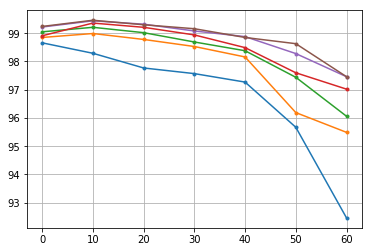

In [56]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

for i in range(6):
    ax.plot([0,10,20,30,40,50,60],trl[0+i*11:7+i*11],'.-')

plt.grid() 
plt.plot()

[]

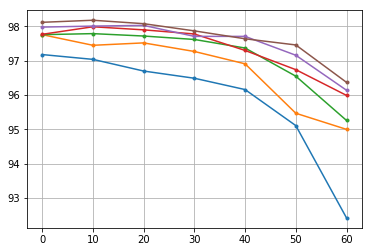

In [57]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

for i in range(6):
    ax.plot([0,10,20,30,40,50,60],tel[0+i*11:7+i*11],'.-')
    
ax.legend(["ciao","coglione"])

plt.grid() 
plt.plot()

In [50]:
for i in range(6):
    print(trl[0+i*11:10+i*11])

[98.66, 98.29, 97.77, 97.57, 97.27, 95.67, 92.46, 89.12, 83.77, 63.84]
[98.85, 98.99, 98.78, 98.53, 98.16, 96.19, 95.49, 93.87, 90.77, 82.46]
[99.05, 99.21, 99.02, 98.69, 98.38, 97.44, 96.06, 94.57, 92.74, 83.46]
[98.91, 99.36, 99.21, 98.94, 98.49, 97.6, 97.02, 95.24, 92.52, 88.49]
[99.22, 99.44, 99.32, 99.08, 98.88, 98.28, 97.46, 96.28, 94.05, 88.79]
[99.24, 99.46, 99.3, 99.16, 98.85, 98.63, 97.46, 96.55, 93.91, 88.94]


In [53]:
for i in range(6):
    print(trl[0+i*11:9+i*11])

[98.66, 98.29, 97.77, 97.57, 97.27, 95.67, 92.46, 89.12, 83.77]
[98.85, 98.99, 98.78, 98.53, 98.16, 96.19, 95.49, 93.87, 90.77]
[99.05, 99.21, 99.02, 98.69, 98.38, 97.44, 96.06, 94.57, 92.74]
[98.91, 99.36, 99.21, 98.94, 98.49, 97.6, 97.02, 95.24, 92.52]
[99.22, 99.44, 99.32, 99.08, 98.88, 98.28, 97.46, 96.28, 94.05]
[99.24, 99.46, 99.3, 99.16, 98.85, 98.63, 97.46, 96.55, 93.91]


[]

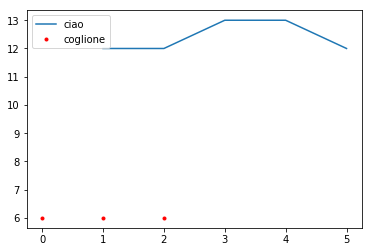

In [229]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.plot([1,2,3,4,5],[12,12,13,13,12])
ax.plot([0,1,2],[6,6,6],'r.')
ax.legend(["ciao","coglione"])
plt.plot()

In [226]:
tr_ac = []
te_ac = []

tr, te = 99.3, 98.13
tr_ac.append(tr)
te_ac.append(te)
tr, te = 99.1, 98.14
x=(20, 30)

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

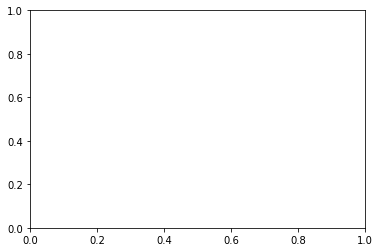

In [222]:


#plt.plot(range(num_epochs), train_errors, c='b')
#plt.plot(range(num_epochs), test_errors, c='r')

plt.plot(x, tr_ac, c='b')
plt.plot(x, te_ac, c='r')
plt.show()

In [174]:
for p in [0,20,40,60,80,90]:
    print("pruning: "+str(p))
    nn_pr = NN_pr(neurons=100, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
    nn_pr.train()

2019-05-23 11:43:02,442 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 0


2019-05-23 11:43:04,332 - INFO - epoch: 0:  99.47
2019-05-23 11:43:04,426 - INFO - Accuracy on Test: 97.8
2019-05-23 11:45:17,086 - INFO - epoch: 100:  99.54
2019-05-23 11:45:17,187 - INFO - Accuracy on Test: 97.9
2019-05-23 11:47:29,178 - INFO - epoch: 200:  99.56
2019-05-23 11:47:29,282 - INFO - Accuracy on Test: 97.91
2019-05-23 11:49:41,907 - INFO - epoch: 300:  99.57
2019-05-23 11:49:42,003 - INFO - Accuracy on Test: 97.94
2019-05-23 11:50:48,154 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 20


2019-05-23 11:50:49,963 - INFO - epoch: 0:  93.47
2019-05-23 11:50:50,064 - INFO - Accuracy on Test: 93.51
2019-05-23 11:53:02,861 - INFO - epoch: 100:  99.26
2019-05-23 11:53:02,958 - INFO - Accuracy on Test: 97.56
2019-05-23 11:55:15,520 - INFO - epoch: 200:  99.35
2019-05-23 11:55:15,618 - INFO - Accuracy on Test: 97.66
2019-05-23 11:57:28,693 - INFO - epoch: 300:  99.39
2019-05-23 11:57:28,792 - INFO - Accuracy on Test: 97.71
2019-05-23 11:58:37,417 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 40


2019-05-23 11:58:39,260 - INFO - epoch: 0:  89.62
2019-05-23 11:58:39,351 - INFO - Accuracy on Test: 90.38
2019-05-23 12:00:59,593 - INFO - epoch: 100:  98.55
2019-05-23 12:00:59,690 - INFO - Accuracy on Test: 97.12
2019-05-23 12:03:21,457 - INFO - epoch: 200:  98.79
2019-05-23 12:03:21,552 - INFO - Accuracy on Test: 97.12
2019-05-23 12:05:43,743 - INFO - epoch: 300:  98.84
2019-05-23 12:05:43,838 - INFO - Accuracy on Test: 97.0
2019-05-23 12:06:54,791 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 60


2019-05-23 12:06:56,653 - INFO - epoch: 0:  86.2
2019-05-23 12:06:56,752 - INFO - Accuracy on Test: 86.87
2019-05-23 12:09:18,410 - INFO - epoch: 100:  95.86
2019-05-23 12:09:18,508 - INFO - Accuracy on Test: 94.77
2019-05-23 12:11:40,168 - INFO - epoch: 200:  96.22
2019-05-23 12:11:40,277 - INFO - Accuracy on Test: 94.94
2019-05-23 12:14:01,678 - INFO - epoch: 300:  96.38
2019-05-23 12:14:01,776 - INFO - Accuracy on Test: 94.97
2019-05-23 12:15:12,570 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 80


2019-05-23 12:15:14,455 - INFO - epoch: 0:  77.75
2019-05-23 12:15:14,562 - INFO - Accuracy on Test: 78.73
2019-05-23 12:17:36,753 - INFO - epoch: 100:  91.73
2019-05-23 12:17:36,847 - INFO - Accuracy on Test: 91.25
2019-05-23 12:19:58,743 - INFO - epoch: 200:  92.21
2019-05-23 12:19:58,846 - INFO - Accuracy on Test: 91.49
2019-05-23 12:22:20,893 - INFO - epoch: 300:  92.38
2019-05-23 12:22:20,987 - INFO - Accuracy on Test: 91.64
2019-05-23 12:23:32,488 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 90


2019-05-23 12:23:34,395 - INFO - epoch: 0:  61.43
2019-05-23 12:23:34,501 - INFO - Accuracy on Test: 61.84
2019-05-23 12:25:57,334 - INFO - epoch: 100:  81.76
2019-05-23 12:25:57,432 - INFO - Accuracy on Test: 81.99
2019-05-23 12:28:20,622 - INFO - epoch: 200:  82.56
2019-05-23 12:28:20,720 - INFO - Accuracy on Test: 82.62
2019-05-23 12:30:43,451 - INFO - epoch: 300:  82.77
2019-05-23 12:30:43,549 - INFO - Accuracy on Test: 83.14


In [47]:
 m=a != 0

In [56]:
b=np.array([[2,2,2],[1,1,1]])

In [60]:
m*b

array([[2, 0, 2],
       [0, 1, 1]])

In [62]:
a=False

In [176]:
nn = NN(neurons=300, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
nn.train()


2019-05-23 12:53:44,859 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 12:53:50,760 - INFO - epoch: 0:  90.28
2019-05-23 12:58:52,626 - INFO - epoch: 100:  99.62
2019-05-23 13:03:37,378 - INFO - epoch: 200:  99.7
2019-05-23 13:03:38,668 - INFO - Accuracy on Test: 98.33


In [177]:
for p in [0,10,20,30,40,50,60,80,90]:
    print("pruning: "+str(p))
    nn_pr = NN_pr(neurons=300, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p)
    nn_pr.train()

pruning: 0


2019-05-23 13:03:39,948 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-23 13:03:44,320 - INFO - epoch: 0:  99.7
2019-05-23 13:03:44,505 - INFO - Accuracy on Test: 98.36
2019-05-23 13:10:14,123 - INFO - epoch: 100:  99.74
2019-05-23 13:10:14,316 - INFO - Accuracy on Test: 98.31
2019-05-23 13:16:53,869 - INFO - epoch: 200:  99.75
2019-05-23 13:16:54,105 - INFO - Accuracy on Test: 98.32
2019-05-23 13:23:29,485 - INFO - epoch: 300:  99.76
2019-05-23 13:23:29,676 - INFO - Accuracy on Test: 98.3
2019-05-23 13:26:47,379 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 10


2019-05-23 13:26:52,393 - INFO - epoch: 0:  96.56
2019-05-23 13:26:52,583 - INFO - Accuracy on Test: 95.81
2019-05-23 13:33:36,158 - INFO - epoch: 100:  99.75
2019-05-23 13:33:36,367 - INFO - Accuracy on Test: 98.26
2019-05-23 13:40:33,418 - INFO - epoch: 200:  99.79
2019-05-23 13:40:33,607 - INFO - Accuracy on Test: 98.22
2019-05-23 13:47:36,070 - INFO - epoch: 300:  99.8
2019-05-23 13:47:36,269 - INFO - Accuracy on Test: 98.24
2019-05-23 13:51:10,728 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 20


2019-05-23 13:51:15,970 - INFO - epoch: 0:  94.16
2019-05-23 13:51:16,167 - INFO - Accuracy on Test: 94.13
2019-05-23 13:58:13,806 - INFO - epoch: 100:  99.64
2019-05-23 13:58:14,011 - INFO - Accuracy on Test: 98.32
2019-05-23 14:05:18,583 - INFO - epoch: 200:  99.71
2019-05-23 14:05:18,784 - INFO - Accuracy on Test: 98.33
2019-05-23 14:12:30,096 - INFO - epoch: 300:  99.73
2019-05-23 14:12:30,295 - INFO - Accuracy on Test: 98.38
2019-05-23 14:16:02,698 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 30


2019-05-23 14:16:07,872 - INFO - epoch: 0:  91.83
2019-05-23 14:16:08,078 - INFO - Accuracy on Test: 92.18
2019-05-23 14:23:11,522 - INFO - epoch: 100:  99.54
2019-05-23 14:23:11,733 - INFO - Accuracy on Test: 98.12
2019-05-23 14:30:14,304 - INFO - epoch: 200:  99.62
2019-05-23 14:30:14,515 - INFO - Accuracy on Test: 98.24
2019-05-23 14:37:20,412 - INFO - epoch: 300:  99.64
2019-05-23 14:37:20,856 - INFO - Accuracy on Test: 98.28
2019-05-23 14:40:53,311 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 40


2019-05-23 14:40:58,555 - INFO - epoch: 0:  90.13
2019-05-23 14:40:58,749 - INFO - Accuracy on Test: 90.68
2019-05-23 14:48:03,887 - INFO - epoch: 100:  99.29
2019-05-23 14:48:04,087 - INFO - Accuracy on Test: 97.61
2019-05-23 14:55:09,255 - INFO - epoch: 200:  99.43
2019-05-23 14:55:09,455 - INFO - Accuracy on Test: 97.8
2019-05-23 15:02:13,409 - INFO - epoch: 300:  99.46
2019-05-23 15:02:13,605 - INFO - Accuracy on Test: 97.82
2019-05-23 15:05:45,830 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 50


2019-05-23 15:05:51,031 - INFO - epoch: 0:  89.54
2019-05-23 15:05:51,226 - INFO - Accuracy on Test: 90.2
2019-05-23 15:12:54,875 - INFO - epoch: 100:  98.78
2019-05-23 15:12:55,087 - INFO - Accuracy on Test: 97.34
2019-05-23 15:19:54,356 - INFO - epoch: 200:  99.05
2019-05-23 15:19:54,556 - INFO - Accuracy on Test: 97.36
2019-05-23 15:26:49,004 - INFO - epoch: 300:  99.1
2019-05-23 15:26:49,206 - INFO - Accuracy on Test: 97.35
2019-05-23 15:30:32,765 - INFO - neurons= 300 learning rate=0.003 momentum update=0.99 minibatch=100


pruning: 60


2019-05-23 15:30:38,092 - INFO - epoch: 0:  88.06
2019-05-23 15:30:38,300 - INFO - Accuracy on Test: 88.98


KeyboardInterrupt: 

In [ ]:
        while self.epoch <= num_epochs:
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            if self.epoch % 100 == 0:
                logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
                logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 

In [129]:
class NN:
    def __init__(self, neurons, training, testing, lr, mu, minibatch, winit):
        self.numEx, self.numTest = 60000, 10000
        self.neurons=neurons
        self.training=training
        self.testing=testing
        self.lr = lr
        self.mu = mu
        self.minibatch=minibatch
        
        #initalizate He at al.
        self.Wh = winit[0]
        self.bh = winit[1]
        self.Wo = winit[2]
        self.bo = winit[3]
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
     
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def predict(self, X):
        outputs=[]
        H=ReLU(np.dot(X, self.Wh)+self.bh)
        outputs.append(H)
        outputs.append(sigmoid((np.dot(H, self.Wo))+self.bo))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch / nEpochs)
        #lr = 10**(-4) + 10**(-1)/math.sqrt(self.epoch+1)
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])        
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) #X[indexLow:indexHigh].T
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += delta_h + momentumUpdate * self.vh
            self.bh += delta_bh + momentumUpdate * self.vbh
            self.Wo += delta_o + momentumUpdate * self.vo  
            self.bo += delta_bo + momentumUpdate * self.vbo
            
            self.vh = delta_h
            self.vbh = delta_bh
            self.vo = delta_o  
            self.vbo = delta_bo
        

    def updateMiniBatch(self, X, t, learningRate):        
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch/400 )
        
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])   
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden)
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += delta_h
            self.bh += delta_bh
            self.Wo += delta_o  
            self.bo += delta_bo
        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
        
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 100
       
        accIter = 0
        
        self.start_time = dt.datetime.now()
        logNN.info("neurons= "+str(self.neurons)+" learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        #logNN.info("learning rate="+str(self.lr)+" Vanilla minibatch(100)")
        while num_epochs >= self.epoch: #not self.stop_iterate(accIter):
            #self.updateMiniBatch(train, self.targetForUpd, self.lr)
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
          #  if self.epoch % 100 == 0:
           #     logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [130]:
class NN_pr1:
    def __init__(self, neurons, training, testing, lr, mu, minibatch, weights, pruning, winit):
        self.numEx, self.numTest = 60000, 10000
        self.neurons=neurons
        self.training=training
        self.testing=testing
        self.lr = lr
        self.mu = mu
        self.minibatch=minibatch
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
            
        self.pruning = pruning
         
        self.maskh = self.pruned_mask(weights[0])
        self.masko = self.pruned_mask(weights[1])
        
        
        self.Wh = winit[0]*self.maskh
        self.bh = winit[1]
        self.Wo = winit[2]*self.masko
        self.bo = winit[3]
        
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def predict(self, X):
        outputs=[]
        H=ReLU(np.dot(X, self.Wh * self.maskh)+self.bh) #
        outputs.append(H)
        outputs.append(sigmoid((np.dot(H, (self.Wo * self.masko)))+self.bo)) # 
        return outputs
    
    def pruned_mask(self, W):
        treshold = self.pruning / 2 
        percentile_down = np.percentile (W, treshold)
        percentile_up = np.percentile (W, 100 - treshold)
        
        m1 = (W >= percentile_down) 
        m2 = (W <= percentile_up)
        mask = m1 * m2

        return mask

    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = 0.0001 + learningRate * math.e ** -(self.epoch / nEpochs)
       
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            hidden, y = self.predict(X[indexLow:indexHigh])        
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
            delta_hidden = np.dot(delta_y, self.Wo.T) * ReLU(hidden, derivate=True)   

            delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) #X[indexLow:indexHigh].T
            delta_o = - lr * np.dot(hidden.T, delta_y)
            delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
            delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

            self.Wh += (delta_h + momentumUpdate * self.vh) * self.maskh
            self.bh += delta_bh + momentumUpdate * self.vbh
            self.Wo += (delta_o + momentumUpdate * self.vo) * self.masko
            self.bo += delta_bo + momentumUpdate * self.vbo
           
            self.vh = delta_h
            self.vbh = delta_bh
            self.vo = delta_o  
            self.vbo = delta_bo
        
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
    
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 100
        accIter = 0
        logNN.info("neurons="+str(self.neurons)+" learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        logNN.info("remove "+str(self.pruning)+"% of connection")
        
        while num_epochs >= self.epoch: #not self.stop_iterate(accIter):
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
          #  if self.epoch % 100 == 0:
           #     logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
                        
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)

In [131]:
trl5=[]
tel5=[]

for n in [100, 150, 200, 250, 300]:
    wInit =[]
    wInit.append(np.random.randn(N_FEATURES, n) * math.sqrt(2.0/60000))
    wInit.append(np.random.randn(1, n) * math.sqrt(2.0/60000))
    wInit.append(np.random.randn(n, 10) * math.sqrt(2.0/60000))
    wInit.append(np.random.randn(1, 10) * math.sqrt(2.0/60000))

    nn = NN(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, winit=wInit)
    tr, te = nn.train()
    trl5.append(tr)
    tel5.append(te)
    for p in [5, 10, 15, 20, 30, 40, 50, 60]:     
        nn_pr = NN_pr1(neurons=n, training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, weights=nn.getWeigth(), pruning=p, winit=wInit)
        tr, te = nn_pr.train()
        trl5.append(tr)
        tel5.append(te)

2019-05-26 01:38:20,206 - INFO - neurons= 100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 01:41:12,801 - INFO - epoch: 101:  99.293
2019-05-26 01:41:12,889 - INFO - Accuracy on Test: 97.95
2019-05-26 01:41:13,574 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 01:41:13,575 - INFO - remove 5% of connection
2019-05-26 01:44:13,564 - INFO - epoch: 101:  99.462
2019-05-26 01:44:13,653 - INFO - Accuracy on Test: 97.6
2019-05-26 01:44:14,268 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 01:44:14,269 - INFO - remove 10% of connection
2019-05-26 01:47:14,979 - INFO - epoch: 101:  99.412
2019-05-26 01:47:15,071 - INFO - Accuracy on Test: 97.6
2019-05-26 01:47:15,689 - INFO - neurons=100 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 01:47:15,689 - INFO - remove 15% of connection
2019-05-26 01:50:16,259 - INFO - epoch: 101:  99.253
2019-05-26 01:50:16,348 - INFO - Accuracy on 

2019-05-26 04:14:20,280 - INFO - epoch: 101:  99.533
2019-05-26 04:14:20,444 - INFO - Accuracy on Test: 98.07
2019-05-26 04:14:21,609 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 04:14:21,610 - INFO - remove 30% of connection
2019-05-26 04:21:39,826 - INFO - epoch: 101:  99.353
2019-05-26 04:21:39,998 - INFO - Accuracy on Test: 97.92
2019-05-26 04:21:41,272 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 04:21:41,273 - INFO - remove 40% of connection
2019-05-26 04:28:54,757 - INFO - epoch: 101:  98.982
2019-05-26 04:28:54,923 - INFO - Accuracy on Test: 97.53
2019-05-26 04:28:56,103 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-26 04:28:56,104 - INFO - remove 50% of connection
2019-05-26 04:36:13,391 - INFO - epoch: 101:  98.425
2019-05-26 04:36:13,557 - INFO - Accuracy on Test: 96.99
2019-05-26 04:36:14,739 - INFO - neurons=250 learning rate=0.003 momentum update=0.99 

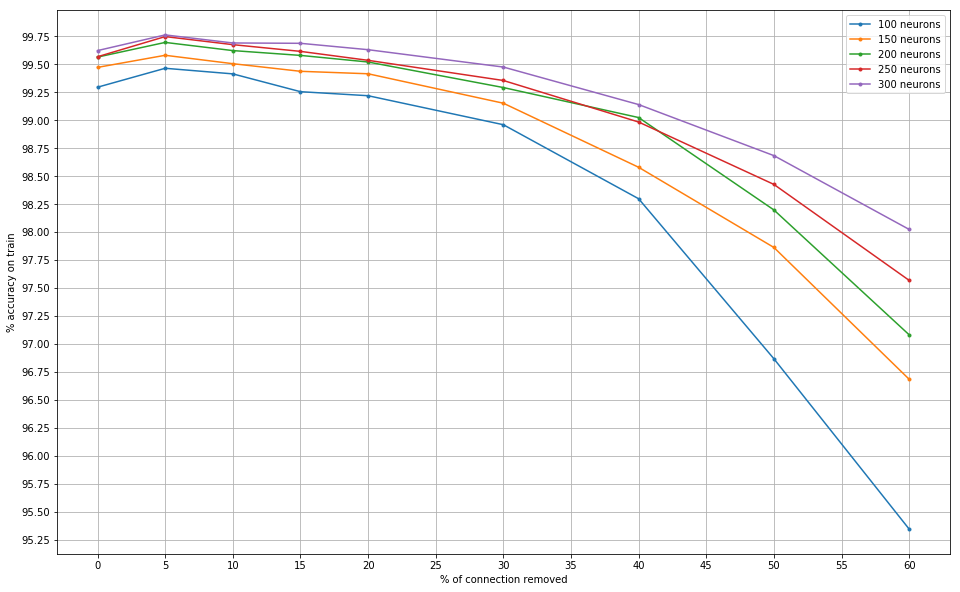

In [135]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],trl5[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(94.5, 100, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on train")
plt.grid() 
plt.plot()
plt.savefig('trainNoRand.png')

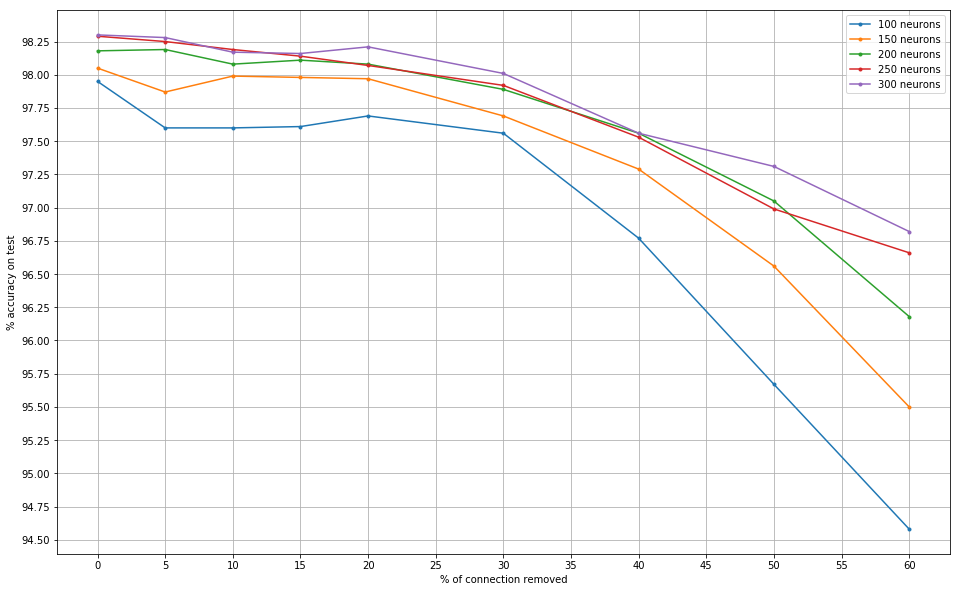

In [134]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)

for i in range(5):
    ax.plot([0,5,10,15,20,30,40,50,60],tel5[0+i*9:(i+1)*9],'.-')
    
ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
plt.xticks(np.arange(0, 61, 5))
plt.yticks(np.arange(94.5, 100, 0.25))
plt.xlabel("% of connection removed")
plt.ylabel("% accuracy on test")
plt.grid() 
plt.plot()
plt.savefig('testNoRand.png')

In [11]:
class NN:
    def __init__(self, training, testing, lr, mu, minibatch):
        self.numEx, self.numTest = 60000, 10000
        self.training = training
        self.testing = testing
        self.lr = lr
        self.mu = mu
        self.minibatch = minibatch
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
        
    def addLayers(self, neurons, nHidden):
        self.epoch = 0
        self.nHidden = nHidden
        self.layers = []
        self.v = []
        for i in range(nHidden):
            n = neurons[i]               
            Wh = np.random.randn(N_FEATURES if i==0 else neurons[i-1], n) * math.sqrt(2.0/self.numEx)
            bWh = np.random.randn(1, n) * math.sqrt(2.0/self.numEx)
            self.layers.append([Wh, bWh])
            self.v.append([0,0])
        Wo = np.random.randn(neurons[-1], 10) * math.sqrt(2.0/self.numEx)
        bWo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        self.layers.append([Wo, bWo])
        self.v.append([0,0])


        
    def predict(self, X):
        outputs=[]
        inputLayer = X
        for i in range(self.nHidden):
            H = ReLU(np.dot(inputLayer, self.layers[i][0]) + self.layers[i][1])
            outputs.append(H)
            inputLayer = H
        outputs.append(sigmoid((np.dot(H, self.layers[-1][0])) + self.layers[-1][1]))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct += 1
        return np.round(correct / lengthX * 100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = learningRate * math.e ** -(self.epoch / nEpochs)

        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            
            if(self.nHidden == 1):
                hidden, y = self.predict(X[indexLow:indexHigh]) 

                delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
                delta_hidden = np.dot(delta_y, self.layers[1][0].T) * ReLU(hidden, derivate=True)   

                delta_h = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden) 
                delta_o = - lr * np.dot(hidden.T, delta_y)
                delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
                delta_bh = - lr * np.sum(delta_hidden, axis=0, keepdims=True)

                self.layers[0][0] += delta_h  + momentumUpdate * self.v[0][0]
                self.layers[0][1] += delta_bh + momentumUpdate * self.v[0][1]
                self.layers[1][0] += delta_o  + momentumUpdate * self.v[1][0]  
                self.layers[1][1] += delta_bo + momentumUpdate * self.v[1][1]

                self.v = [[delta_h, delta_bh], [delta_o, delta_bo]]
           
            elif (self.nHidden == 2):
                hidden1, hidden2, y = self.predict(X[indexLow:indexHigh]) 
                delta_y = y * (1-y) * (y-t[indexLow:indexHigh])       
                delta_hidden2 = np.dot(delta_y, self.layers[2][0].T) * ReLU(hidden2, derivate=True)
                delta_hidden1 = np.dot(delta_hidden2, self.layers[1][0].T) * ReLU(hidden1, derivate=True)
                
                delta_h1 = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden1) 
                delta_h2 = - lr * np.dot(hidden1.T, delta_hidden2) 
                delta_o = - lr * np.dot(hidden2.T, delta_y)
                delta_bh1 = - lr * np.sum(delta_hidden1, axis=0, keepdims=True)
                delta_bh2 = - lr * np.sum(delta_hidden2, axis=0, keepdims=True)
                delta_bo = - lr * np.sum(delta_y, axis=0, keepdims=True)
                
                deltas=[[delta_h1, delta_bh1], [delta_h2, delta_bh2], [delta_o, delta_bo]]
                for i in range(self.nHidden + 1):
                    self.layers[i][0] += deltas[i][0]  + momentumUpdate * self.v[i][0]
                    self.layers[i][1] += deltas[i][1] + momentumUpdate * self.v[i][1]
                
                self.v = deltas
                


    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 200
       
        accIter = 0
        
        self.start_time = dt.datetime.now()
        logNN.info("learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        while num_epochs >= self.epoch: 
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [12]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
nn.addLayers([10,5], 2)
nn.train()

2019-06-01 19:10:20,528 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-01 19:12:23,703 - INFO - epoch: 201:  94.892
2019-06-01 19:12:23,758 - INFO - Accuracy on Test: 93.34


(94.892, 93.34)

In [236]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
nn.addLayers([300,100], 2)
nn.train()

2019-05-31 23:40:58,432 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-31 23:49:05,750 - INFO - epoch: 101:  99.688
2019-05-31 23:49:05,961 - INFO - Accuracy on Test: 98.18


(99.688, 98.18)

In [245]:
nn.addLayers([250,100], 2)
nn.train()

2019-06-01 00:18:38,976 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-01 00:33:39,687 - INFO - epoch: 201:  99.76
2019-06-01 00:33:39,885 - INFO - Accuracy on Test: 98.14


(99.76, 98.14)

In [241]:
nn.addLayers([250,50], 2)
nn.train()

2019-06-01 00:02:52,893 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-01 00:09:36,121 - INFO - epoch: 101:  99.68
2019-06-01 00:09:36,320 - INFO - Accuracy on Test: 98.04


(99.68, 98.04)

In [238]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100)
nn.addLayers([300], 1)
nn.train()

2019-05-31 23:49:50,987 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-05-31 23:57:23,677 - INFO - epoch: 101:  99.58
2019-05-31 23:57:23,891 - INFO - Accuracy on Test: 98.32


(99.58, 98.32)

In [46]:
class NN:
    def __init__(self, training, testing, lr, mu, minibatch):
        self.numEx, self.numTest = 60000, 10000
        self.training = training
        self.testing = testing
        self.lr = lr
        self.mu = mu
        self.minibatch = minibatch
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
        
    def addLayers(self, neurons, nHidden):
        self.epoch = 0
        self.nHidden = nHidden
        self.layers = []
        self.v = []
        for i in range(nHidden):
            n = neurons[i]               
            Wh = np.random.randn(N_FEATURES if i==0 else neurons[i-1], n) * math.sqrt(2.0/self.numEx)
            bWh = np.random.randn(1, n) * math.sqrt(2.0/self.numEx)
            self.layers.append([Wh, bWh])
            self.v.append([0,0])
        Wo = np.random.randn(neurons[-1], 10) * math.sqrt(2.0/self.numEx)
        bWo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        self.layers.append([Wo, bWo])
        self.v.append([0,0])


        
    def predict(self, X):
        outputs=[]
        inputLayer = X
        for i in range(self.nHidden):
            H = ReLU(np.dot(inputLayer, self.layers[i][0]) + self.layers[i][1])
            outputs.append(H)
            inputLayer = H
        outputs.append(sigmoid((np.dot(H, self.layers[-1][0])) + self.layers[-1][1]))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct += 1
        return np.round(correct / lengthX * 100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = learningRate * math.e ** -(self.epoch / nEpochs)

        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            
            outputs = self.predict(X[indexLow:indexHigh])
            y = outputs[-1]
            deltas = []
            deltas.append(y * (1-y) * (y-t[indexLow:indexHigh]))
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])
            for i in range(self.nHidden):
                deltas.append(np.dot(deltas[i], self.layers[self.nHidden - i][0].T) * ReLU(outputs[self.nHidden-i-1], derivate=True))

            deltas.reverse()

            deltasUpd = []
            deltasUpd.append([- lr * np.dot(X[indexLow:indexHigh].T, deltas[0]), - lr * np.sum(deltas[0], axis=0, keepdims=True)])
            for i in range(self.nHidden):
                deltasUpd.append([- lr * np.dot(outputs[i].T, deltas[i+1])  , - lr * np.sum(deltas[i+1], axis=0, keepdims=True)])

            for i in range(self.nHidden + 1):
                self.layers[i][0] += deltasUpd[i][0]  + momentumUpdate * self.v[i][0]
                self.layers[i][1] += deltasUpd[i][1] + momentumUpdate * self.v[i][1]

            self.v = deltasUpd



    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 80
       
        accIter = 0
        
        self.start_time = dt.datetime.now()
        logNN.info("learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        while num_epochs > self.epoch: 
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [141]:
class NN:
    def __init__(self, training, testing, lr, mu, minibatch, dropout):
        self.numEx, self.numTest = 60000, 10000
        self.training = training
        self.testing = testing
        self.lr = lr
        self.mu = mu
        self.minibatch = minibatch
        self.p=dropout
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
        
    def addLayers(self, neurons):
        self.epoch = 0
        self.nHidden = len(neurons)
        self.layers = []
        self.v = []
        for i in range(self.nHidden):
            n = neurons[i]               
            Wh = np.random.randn(N_FEATURES if i==0 else neurons[i-1], n) * math.sqrt(2.0/self.numEx)
            bWh = np.random.randn(1, n) * math.sqrt(2.0/self.numEx)
            self.layers.append([Wh, bWh])
            self.v.append([0,0])
        Wo = np.random.randn(neurons[-1], 10) * math.sqrt(2.0/self.numEx)
        bWo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        self.layers.append([Wo, bWo])
        self.v.append([0,0])
   
    def predict(self, X):
        outputs=[]
        inputLayer = X
        for i in range(self.nHidden):
            H = ReLU(np.dot(inputLayer, self.layers[i][0]) + self.layers[i][1])
            outputs.append(H)
            inputLayer = H
        outputs.append(sigmoid((np.dot(H, self.layers[-1][0])) + self.layers[-1][1]))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct += 1
        return np.round(correct / lengthX * 100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = learningRate * math.e ** -(self.epoch / nEpochs)
        p = self.p
       
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            outputs = []
            
            outputs = self.predict(X[indexLow:indexHigh])
            for i in range(len(outputs) - 1):
                mask = (np.random.rand(*outputs[i].shape) < p) / p
                outputs[i] *= mask
            
            y = outputs[-1]
            deltas = []
            deltas.append(y * (1-y) * (y-t[indexLow:indexHigh]))
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])
            for i in range(self.nHidden):
                deltas.append(np.dot(deltas[i], self.layers[self.nHidden - i][0].T) * ReLU(outputs[self.nHidden-i-1], derivate=True))

            deltas.reverse()

            deltasUpd = []
            deltasUpd.append([- lr * np.dot(X[indexLow:indexHigh].T, deltas[0]), - lr * np.sum(deltas[0], axis=0, keepdims=True)])
            for i in range(self.nHidden):
                deltasUpd.append([- lr * np.dot(outputs[i].T, deltas[i+1])  , - lr * np.sum(deltas[i+1], axis=0, keepdims=True)])

            for i in range(self.nHidden + 1):
                self.layers[i][0] += deltasUpd[i][0]  + momentumUpdate * self.v[i][0]
                self.layers[i][1] += deltasUpd[i][1] + momentumUpdate * self.v[i][1]

            self.v = deltasUpd

    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 100
        
        self.start_time = dt.datetime.now()
        logNN.info("learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        while num_epochs > self.epoch: 
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            
            if self.epoch % 5 == 0:
                logNN.debug("Accuracy - epoch "+str(self.epoch)+":  Train="+str(self.accuracy(train, self.target_train)))+" - Test="+str(self.accuracy(test, self.target_test)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("Train acc - epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Test acc - epoch:"+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [133]:
for p in [1, .75, .5, .25]:  
    print("dropout: " + str(p))
    nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=p)
    nn.addLayers([200, 100, 50])
    nn.train()

2019-06-02 13:23:37,463 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100


dropout: 1


2019-06-02 13:40:16,362 - INFO - Train acc - epoch: 200:  99.537
2019-06-02 13:40:16,537 - INFO - Test acc - epoch:97.74
2019-06-02 13:40:17,758 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100


dropout: 0.75


2019-06-02 13:56:06,824 - INFO - Train acc - epoch: 200:  99.57
2019-06-02 13:56:06,997 - INFO - Test acc - epoch:97.52
2019-06-02 13:56:08,210 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100


dropout: 0.5


2019-06-02 14:11:14,929 - INFO - Train acc - epoch: 200:  99.488
2019-06-02 14:11:15,111 - INFO - Test acc - epoch:97.71
2019-06-02 14:11:16,320 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100


dropout: 0.25


2019-06-02 14:27:01,846 - INFO - Train acc - epoch: 200:  97.972
2019-06-02 14:27:02,021 - INFO - Test acc - epoch:96.65


In [139]:
for p in [1, .75, .5]:  
    print("dropout: " + str(p))
    nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=p)
    nn.addLayers([100, 60, 30])
    nn.train()

2019-06-02 15:30:05,494 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100


dropout: 1


KeyboardInterrupt: 

In [140]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([200, 100, 50])
nn.train()

2019-06-02 15:30:53,477 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 15:38:33,733 - INFO - Train acc - epoch: 100:  99.625
2019-06-02 15:38:33,906 - INFO - Test acc - epoch:97.5


(99.625, 97.5)

In [142]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([200, 100, 50])
nn.train()

2019-06-02 18:00:56,998 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
/home/giosumarin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/giosumarin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/giosumarin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/home/giosumarin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


KeyboardInterrupt: 

In [4]:
def softmax(scores):
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [9]:
a=np.array([[1,2,3],[6,5,5]])
b=softmax(a)
dscores[range(num_examples),y] -= 1
b

array([[-0.90996943,  0.24472847,  0.66524096],
       [ 0.57611688, -0.78805844,  0.21194156]])

In [7]:
dscores[range(num_examples),y] -= 1

array([[1, 2, 3],
       [6, 5, 5]])

In [167]:
np.argmax(b, axis=1).reshape(-1,1)

array([[2],
       [0]])

In [163]:
a = np.array([[1,2,3],[5,6,7]])

In [164]:
*a.shape

SyntaxError: can't use starred expression here (cell_name, line 4)

In [ ]:
class NN:
    def __init__(self, training, testing, lr, mu, minibatch):
        self.numEx, self.numTest = 60000, 10000
        self.training = training
        self.testing = testing
        self.lr = lr
        self.mu = mu
        self.minibatch = minibatch
        self.layers = []
        
        #initalizate He at al.
        #self.Wh = 0
        #self.bh = 0
        #self.Wo = np.random.randn(self.neurons, 10) * math.sqrt(2.0/self.numEx)
        #self.bo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
     
        self.epoch = 0
        self.vh = 0
        self.vo = 0 
        self.vbh = 0
        self.vbo = 0
        
        self.best_acc = 0
        
    def addLayers(self, neurons, nHidden):
        self.nHidden = nHidden
        self.v = []
        for i in range(nHidden):
            n = neurons[i]               
            Wh = np.random.randn(N_FEATURES if i==0 else neurons[i-1], n) * math.sqrt(2.0/self.numEx)
            bWh = np.random.randn(1, n) * math.sqrt(2.0/self.numEx)
            self.layers.append([Wh, bWh])
            self.v.append([0,0])
        Wo = np.random.randn(neurons[-1], 10) * math.sqrt(2.0/self.numEx)
        bWo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        self.layers.append([Wo, bWo])
        self.v.append([0,0])
        
    def predict(self, X):
        outputs=[]
        inputLayer = X
        for i in range(len(self.layers) - 1):
            H = ReLU(np.dot(inputLayer, self.layers[i][0]) + self.layers[i][1])
            outputs.append(H)
            inputLayer = H
        outputs.append(sigmoid((np.dot(H, self.layers[-1][0])) + self.layers[-1][1]))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct+=1
        return np.round(correct/lengthX*100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = learningRate * math.e ** -(self.epoch / nEpochs)

        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            #hidden1, hidden2, y = self.predict(X[indexLow:indexHigh])
            hidden2, y = self.predict(X[indexLow:indexHigh]) 
            deltas = []
            deltas.append(y * (1-y) * (y-t[indexLow:indexHigh]))   #delta_y =   
            deltas.append(np.dot(deltas[0], self.layers[1][0].T) * ReLU(hidden2, derivate=True))   #delta_hidden2
           # delta_hidden1 = np.dot(delta_hidden2, self.Wh.T) * ReLU(hidden1, derivate=True) 

        deltasUpd = []
        
        deltasUpd.append([- lr * np.dot(hidden2.T, deltas[0]), - lr * np.sum(deltas[0], axis=0, keepdims=True)])
        for i in range(self.nHidden):
            #delta_h1 = - lr * np.dot(X[indexLow:indexHigh].T, delta_hidden1)
            #delta_h2 = - lr * np.dot(hidden1.T, delta_hidden2)
            deltasUpd.append([- lr * np.dot(X[indexLow:indexHigh].T, deltas[i+1]), - lr * np.sum(deltas[i+1], axis=0, keepdims=True)])
          
            
            #delta_bh1 = - lr * np.sum(delta_hidden1, axis=0, keepdims=True)
        deltasUpd = deltasUpd[::-1]
        for i in range(self.nHidden + 1):
            self.layers[i][0] += deltasUpd[i][0] + momentumUpdate * self.v[i][0] #sistemare V, rendere vettore
            self.layers[i][1] += deltasUpd[i][1] + momentumUpdate * self.v[i][1]
            self.v[i][0] = deltasUpd[i][0]
            self.v[i][1] = deltasUpd[i][1]
                
                #self.layers[1][0] += delta_o + momentumUpdate * self.vo  
                #self.layers[1][1] += delta_bo + momentumUpdate * self.vbo
            
            #self.vh = delta_h2
            #self.vbh = delta_bh2
            #self.vo = delta_o  
            #self.vbo = delta_bo
        

        
    def stop_iterate(self, acc):
        if acc == 0:
            self.best_acc = acc
            return False
        elif acc - self.best_acc >= 0.005:
            self.best_acc = acc
            return False
        return True
        
    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 20
       
        accIter = 0
        
        self.start_time = dt.datetime.now()
        logNN.info("learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        while num_epochs >= self.epoch: 
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            
            if self.epoch % 5 == 0:
                logNN.debug("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))
            
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Accuracy on Test: "+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return self.accuracy(train, self.target_train), self.accuracy(test, self.target_test)
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [35]:
class NN:
    def __init__(self, training, testing, lr, mu, minibatch, dropout):
        self.numEx, self.numTest = 60000, 10000
        self.training = training
        self.testing = testing
        self.lr = lr
        self.mu = mu
        self.minibatch = minibatch
        self.p=dropout
        
        self.target_train = self.training[1][0:self.numEx]
        self.target_test = self.testing[1][0:self.numTest]
        
        self.targetForUpd=np.zeros((self.numEx, 10), dtype=int)
        for i in range(self.numEx):
            self.targetForUpd[i,training[1][i]] = 1
        
    def addLayers(self, neurons):
        self.epoch = 0
        self.nHidden = len(neurons)
        self.layers = []
        self.v = []
        for i in range(self.nHidden):
            n = neurons[i]               
            Wh = np.random.randn(N_FEATURES if i==0 else neurons[i-1], n) * math.sqrt(2.0/self.numEx)
            bWh = np.random.randn(1, n) * math.sqrt(2.0/self.numEx)
            self.layers.append([Wh, bWh])
            self.v.append([0,0])
        Wo = np.random.randn(neurons[-1], 10) * math.sqrt(2.0/self.numEx)
        bWo = np.random.randn(1, 10) * math.sqrt(2.0/self.numEx)
        self.layers.append([Wo, bWo])
        self.v.append([0,0])
   
    def predict(self, X):
        outputs=[]
        inputLayer = X
        for i in range(self.nHidden):
            H = ReLU(np.dot(inputLayer, self.layers[i][0]) + self.layers[i][1])
            outputs.append(H)
            inputLayer = H
        outputs.append(sigmoid((np.dot(H, self.layers[-1][0])) + self.layers[-1][1]))
        return outputs
        
    def predictHotClass(self, X):
        return np.argmax(self.predict(X)[-1], axis=1).reshape(-1,1)
    
    def accuracy(self, X, t):
        lengthX = X.shape[0]
        correct = 0
        predictons = self.predictHotClass(X)
        for i in range(lengthX): 
            if predictons[i] == t[i]:     
                correct += 1
        return np.round(correct / lengthX * 100, 3)
        
    def updateMomentum(self, X, t, nEpochs, learningRate, momentumUpdate):
        numBatch = (int)(self.numEx/self.minibatch)
        lr = learningRate * math.e ** -(self.epoch / nEpochs)
        p = self.p
       
        for nb in range(numBatch):
            indexLow = nb*self.minibatch
            indexHigh = (nb+1)*self.minibatch
            outputs = []
            
            outputs = self.predict(X[indexLow:indexHigh])
            for i in range(len(outputs) - 1):
                mask = (np.random.rand(*outputs[i].shape) < p) / p
                outputs[i] *= mask
            
            y = outputs[-1]
            deltas = []
            deltas.append(y * (1-y) * (y-t[indexLow:indexHigh]))
            delta_y = y * (1-y) * (y-t[indexLow:indexHigh])
            for i in range(self.nHidden):
                deltas.append(np.dot(deltas[i], self.layers[self.nHidden - i][0].T) * ReLU(outputs[self.nHidden-i-1], derivate=True))

            deltas.reverse()

            deltasUpd = []
            deltasUpd.append([- lr * np.dot(X[indexLow:indexHigh].T, deltas[0]), - lr * np.sum(deltas[0], axis=0, keepdims=True)])
            for i in range(self.nHidden):
                deltasUpd.append([- lr * np.dot(outputs[i].T, deltas[i+1])  , - lr * np.sum(deltas[i+1], axis=0, keepdims=True)])

            for i in range(self.nHidden + 1):
                self.layers[i][0] += deltasUpd[i][0]  + momentumUpdate * self.v[i][0]
                self.layers[i][1] += deltasUpd[i][1] + momentumUpdate * self.v[i][1]

            self.v = deltasUpd

    def train(self):
        train=self.training[0][0:self.numEx]
        test=self.testing[0][0:self.numTest]
        num_epochs = 100
        
        tr=[]
        te=[]
        
        self.start_time = dt.datetime.now()
        logNN.info("learning rate="+str(self.lr)+ " momentum update=" +str(self.mu)+" minibatch="+str(self.minibatch))
        while num_epochs > self.epoch: 
            self.updateMomentum(train, self.targetForUpd, num_epochs, self.lr, self.mu)
            
            tr.append(self.accuracy(train, self.target_train))
            te.append(self.accuracy(test, self.target_test))
            
            if self.epoch % 5 == 0:
                logNN.debug("Accuracy - epoch "+str(self.epoch)+":  Train="+str(self.accuracy(train, self.target_train))+"Test="+str(self.accuracy(test, self.target_test)))
                
            self.epoch += 1 
            accIter = self.accuracy(train, self.target_train)
           
        logNN.info("Train acc - epoch: "+str(self.epoch)+":  "+str(self.accuracy(train, self.target_train)))               
        logNN.info("Test acc - epoch:"+str(self.accuracy(test, self.target_test)))
        logNN.debug("---------------------------------------------------------------------")
        return tr, te
        
    def getWeigth(self):
        return self.Wh, self.Wo, self.bh, self.bo
       

In [18]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([200, 100, 50])
o1 = nn.train()
nn.addLayers([300, 150, 50])
o2 = nn.train()
nn.addLayers([300, 100])
o3 = nn.train()

2019-06-02 21:58:46,199 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 22:08:40,609 - INFO - Train acc - epoch: 100:  99.413
2019-06-02 22:08:40,775 - INFO - Test acc - epoch:97.55
2019-06-02 22:08:40,789 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 22:24:19,910 - INFO - Train acc - epoch: 100:  99.465
2019-06-02 22:24:20,147 - INFO - Test acc - epoch:97.57
2019-06-02 22:24:20,160 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 22:38:48,245 - INFO - Train acc - epoch: 100:  99.71
2019-06-02 22:38:48,476 - INFO - Test acc - epoch:98.29


In [38]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.5)
nn.addLayers([300, 100])
o4 = nn.train()

2019-06-03 20:32:10,260 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-03 20:44:14,758 - INFO - Train acc - epoch: 100:  99.632
2019-06-03 20:44:15,057 - INFO - Test acc - epoch:98.22


In [43]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=1000, dropout=.75)
nn.addLayers([300, 100])
o6 = nn.train()

2019-06-03 20:49:15,866 - INFO - learning rate=0.003 momentum update=0.99 minibatch=1000
2019-06-03 20:59:37,753 - INFO - Train acc - epoch: 100:  99.777
2019-06-03 20:59:38,170 - INFO - Test acc - epoch:98.2


In [44]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=1000, dropout=.5)
nn.addLayers([300, 100])
o6 = nn.train()

2019-06-03 21:02:40,023 - INFO - learning rate=0.003 momentum update=0.99 minibatch=1000
2019-06-03 21:14:01,654 - INFO - Train acc - epoch: 100:  99.717
2019-06-03 21:14:02,228 - INFO - Test acc - epoch:98.2


In [19]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.5)
nn.addLayers([300, 100])
o4 = nn.train()

nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.25)
nn.addLayers([300, 100])
o5 = nn.train()

2019-06-02 22:38:56,183 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 22:53:18,240 - INFO - Train acc - epoch: 100:  99.622
2019-06-02 22:53:18,470 - INFO - Test acc - epoch:98.22
2019-06-02 22:53:18,520 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 23:07:38,967 - INFO - Train acc - epoch: 100:  99.29
2019-06-02 23:07:39,198 - INFO - Test acc - epoch:97.89


In [20]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([200, 100, 50])
o6 = nn.train()

2019-06-02 23:18:02,318 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 23:28:21,250 - INFO - Train acc - epoch: 100:  99.41
2019-06-02 23:28:21,456 - INFO - Test acc - epoch:97.48


In [21]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([120, 60, 30])
o6 = nn.train()

2019-06-02 23:28:43,507 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-02 23:35:36,229 - INFO - Train acc - epoch: 100:  99.082
2019-06-02 23:35:36,364 - INFO - Test acc - epoch:97.28


In [23]:
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=1.)
nn.addLayers([300,150])
o6 = nn.train()
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.75)
nn.addLayers([300,150])
o7 = nn.train()
nn = NN(training=TRAINING, testing=TESTING, lr=0.003, mu=.99, minibatch=100, dropout=.5)
nn.addLayers([300,150])
o8 = nn.train()

2019-06-02 23:45:53,927 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-03 00:01:14,707 - INFO - Train acc - epoch: 100:  99.673
2019-06-03 00:01:14,941 - INFO - Test acc - epoch:98.19
2019-06-03 00:01:14,981 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-03 00:16:32,029 - INFO - Train acc - epoch: 100:  99.688
2019-06-03 00:16:32,303 - INFO - Test acc - epoch:98.21
2019-06-03 00:16:32,352 - INFO - learning rate=0.003 momentum update=0.99 minibatch=100
2019-06-03 00:31:43,327 - INFO - Train acc - epoch: 100:  99.672
2019-06-03 00:31:43,543 - INFO - Test acc - epoch:98.15


[]

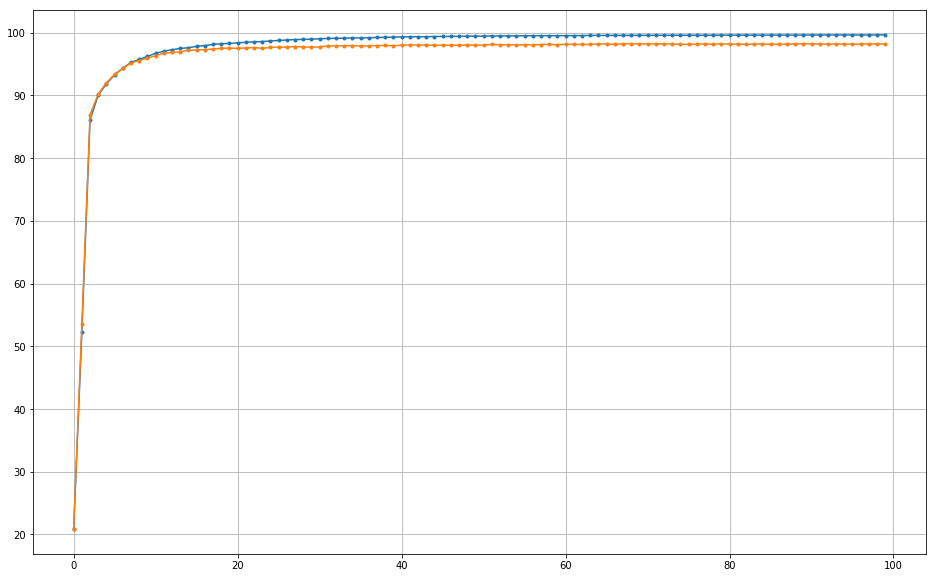

In [41]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1,1,1)


ax.plot(range(100),o4[0],'.-')
ax.plot(range(100),o4[1],'.-')
    
#ax.legend(["100 neurons","150 neurons", "200 neurons", "250 neurons", "300 neurons"])
#plt.xticks(np.arange(0, 61, 5))
#plt.yticks(np.arange(94.5, 100, 0.25))
#plt.xlabel("% of connection removed")
#plt.ylabel("% accuracy on test")
plt.grid() 
plt.plot()
#plt.savefig('testNoRand.png')